**NLP**

- https://www.kaggle.com/abhishekmyana/toxicity-classification

- https://towardsdatascience.com/classify-toxic-online-comments-with-lstm-and-glove-e455a58da9c7


- https://github.com/susanli2016/NLP-with-Python/blob/master/Toxic%20Comments%20LSTM%20GloVe.ipynb


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import json
import glob
from PIL import Image
import re
import random

from tqdm import tqdm_notebook

from nltk.corpus import stopwords
import tensorflow as tf 
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

#Change working directory

In [3]:
import os

os.chdir('/content/drive/My Drive/FourthBrain/individual_project')
PATH = '/content/drive/My Drive/FourthBrain/individual_project'

#Data Loader

In [12]:
#!wget https://nlp.stanford.edu/data/glove.6B.zip

--2021-10-29 12:47:25--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-10-29 12:47:26--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  4.86MB/s    in 2m 40s  

2021-10-29 12:50:06 (5.13 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [14]:
#!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [4]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 200 # max length of each entry (sentence), including padding
EMBEDDING_DIM = 100      # embedding dimensions for word vectors (word2vec/GloVe)
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
GLOVE_DIR = "glove.6B." + str(EMBEDDING_DIM) + "d.txt"

In [5]:
#!ls

#Load data

In [6]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
print(df_train.dtypes,'\n')
print(df_train.shape,'\n')
print(df_train.describe())

id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object 

(159571, 8) 

               toxic   severe_toxic  ...         insult  identity_hate
count  159571.000000  159571.000000  ...  159571.000000  159571.000000
mean        0.095844       0.009996  ...       0.049364       0.008805
std         0.294379       0.099477  ...       0.216627       0.093420
min         0.000000       0.000000  ...       0.000000       0.000000
25%         0.000000       0.000000  ...       0.000000       0.000000
50%         0.000000       0.000000  ...       0.000000       0.000000
75%         0.000000       0.000000  ...       0.000000       0.000000
max         1.000000       1.000000  ...       1.000000       1.000000

[8 rows x 6 columns]


#Count number of comments for each category

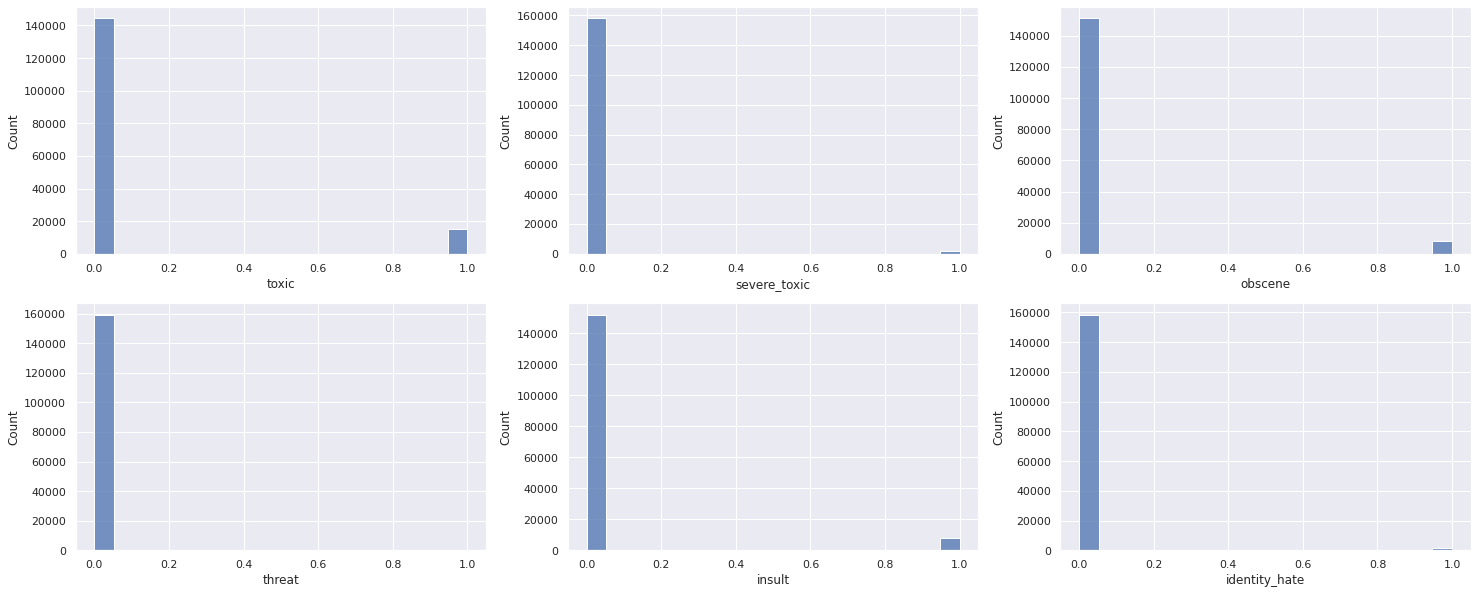

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="darkgrid")

labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
# Define the number of rows and columns you want
n_rows=2
n_cols=3
# Create the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(25, 10))


for i, column in enumerate(labels, 1):
    plt.subplot(2,3,i)
    sns.histplot(data = df_train, x = column)

#Check missing values

In [9]:
df_train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [10]:
df_test.isnull().sum()

id              0
comment_text    0
dtype: int64

#Clean text

In [11]:
def preprocess_text(text, remove_stopwords = True):
    output = ""
    text = str(text).replace("\n", "")
    text = re.sub(r'[^\w\s]','',text).lower()
    if remove_stopwords:
        text = text.split(" ")
        for word in text:
            if word not in stopwords.words("english"):
                output = output + " " + word
    else:
        output = text
    return str(output.strip())[1:-3].replace("  ", " ")


In [12]:
import nltk
nltk.download('stopwords')

comment_text = []
for text in tqdm_notebook(df_train['comment_text'].to_list()):
  comment_text.append(preprocess_text(text))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/159571 [00:00<?, ?it/s]

In [15]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(comment_text)


In [16]:
sequences = tokenizer.texts_to_sequences(comment_text)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 324669


#Create the model

In [17]:
#Pad after each sequence.
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
y = df_train[labels].values
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (159571, 200)
Shape of label tensor: (159571, 6)


In [18]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

In [19]:
num_validation_samples = int(VALIDATION_SPLIT*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]

In [20]:
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [12308  1305  6816   384  6347  1116]
validation:  [2986  290 1633   94 1530  289]


In [21]:
print('Tokenized sentences: \n', data[10])
print('One hot label: \n', labels[10])

Tokenized sentences: 
 [ 6182   154     5  2836   118   228  6119   148   404   430   273   142
  5347  1893   404   747   200    93    27  1224  1004   874   353  3651
   118 29525   730  2597 80701  1728 50756   148 29525   444 80701  1803
  9485  4301 10011 80702  1983  1045  6540 13580    81   243 43880   362
  4934    13    12     4    38   856  1850   338  1031  1334  3651   573
   220  3651 80703    75   220    48    75   220    48   172   171  4669
  2723  1081   730   117   588  1599     5    96    21     3     4   805
   255  2808   973   327 38779 38780  3566 50756  4000  3012  7734   983
 43880 50756  5018   742  2120  2808  1173   659  9801   268   113  3651
 11359  6025 38780     4   173  1205    25  1080   911   666   918   404
   666   587 14720     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0    

In [22]:
embeddings_index = {}
f = open(GLOVE_DIR)
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [23]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)

- The loss function to be used is indeed the binary_crossentropy with a sigmoid activation.

- The categorical_crossentropy is not suitable for multi-label problems, because in case of the multi-label problems, the labels are not mutually exclusive. Repeat the last sentence: the labels are not mutually exclusive.

- This means that the presence of a label in the form [1,0,1,0,0,0] is correct. The categorical_crossentropy and softmax will always tend to favour one specific class, but this is not the case; just like you saw, a comment can be both toxic and obscene.

- Now imagine photos with cats and dogs inside them. What happens if we have 2 dogs and 2 cats inside a photo? Is it a dog picture or a cat picture? It is actually a "both" picture! We definitely need a way to specify that multiple labels are pertained/related to a photo/label.

- The rationale for using the binary_crossentropy and sigmoid for multi-label classification resides in the mathematical properties, in that each output needs to be treated as in independent Bernoulli distribution.

- Therefore, the only correct solution is BCE + 'sigmoid'.

In [24]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="sigmoid")(x)

In [25]:
model = Model(sequence_input, preds)
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embeddings (Embedding)       (None, 200, 100)          32467000  
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           38640     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0     

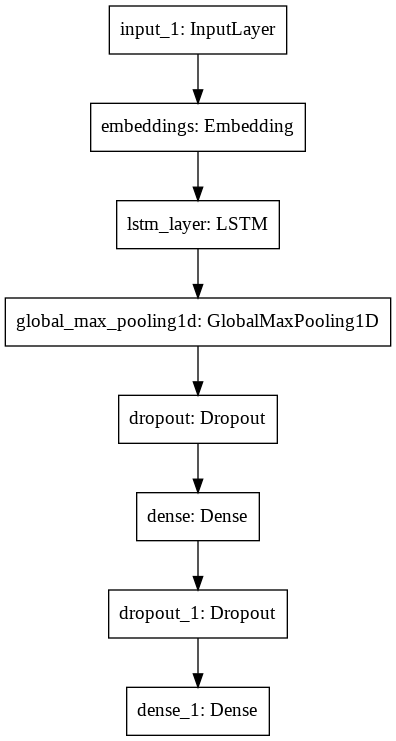

In [26]:
tf.keras.utils.plot_model(model)

In [28]:
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 2, batch_size=32, validation_data=(x_val, y_val))

Training progress:
Epoch 1/2
3990/3990 [==============================] - 47s 11ms/step - loss: 0.0796 - accuracy: 0.9397 - val_loss: 0.0640 - val_accuracy: 0.9935
Epoch 2/2
3990/3990 [==============================] - 42s 11ms/step - loss: 0.0648 - accuracy: 0.9844 - val_loss: 0.0602 - val_accuracy: 0.9938


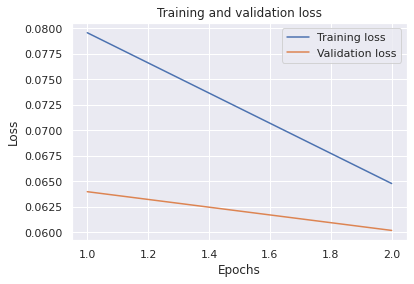

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

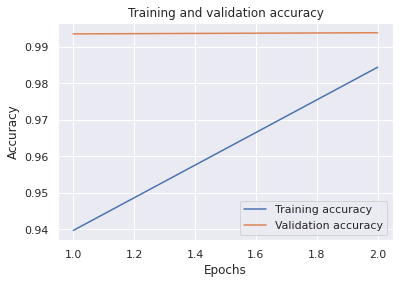

In [30]:

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

In [31]:
!ls

cf_matrix.py	   nlp-classification.ipynb  toxic-classification-flair.ipynb
dataset		   __pycache__		     toxic-classification-lstm.ipynb
eda.ipynb	   sample_submission.csv     train.csv
glove.6B.100d.txt  test.csv
model.png	   test_labels.csv


In [46]:
test_sequences = tokenizer.texts_to_sequences(df_test['comment_text']) 
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

test_labels =  pd.read_csv('test_labels.csv')
test_labels =  test_labels.iloc[:,1:]
#test_labels = to_categorical(np.asarray(test_labels))


Test accuracy with RNN: [[7.96721160e-01 3.38684507e-02 4.48564768e-01 1.62335094e-02
  4.80266571e-01 5.57642095e-02]
 [1.00257486e-01 1.46095816e-03 2.21086498e-02 6.27904898e-04
  4.13953252e-02 2.00101128e-03]
 [1.19847558e-01 4.45641531e-03 4.54119220e-02 1.15128560e-03
  6.57942593e-02 2.59156828e-03]
 ...
 [2.94272229e-02 1.16779840e-04 4.07120259e-03 1.58710958e-04
  8.65675975e-03 8.17191612e-04]
 [4.64337170e-02 1.80858318e-04 3.79697978e-03 3.70020600e-04
  1.12189036e-02 7.22059514e-03]
 [5.67981541e-01 1.56876203e-02 2.17786998e-01 4.64251125e-03
  2.89836586e-01 1.16103292e-02]]


In [57]:
y_pred = model.predict(test_data)
y_pred[0]

array([0.79672116, 0.03386845, 0.44856477, 0.01623351, 0.48026657,
       0.05576421], dtype=float32)

In [61]:
#class_labels=[labels[i] for i,prob in enumerate(y_pred) if prob > 0.5]
#class_labels
for i,prob in enumerate(y_pred[0]):
  if prob > 0.5:
    print(labels[i])


toxic


In [62]:
threshold = 0.5
y_pred = np.where(y_pred > threshold, 1,0)

In [63]:
y_pred[0]

array([1, 0, 0, 0, 0, 0])